TEAM MEMEBERS

SUMEDH SS-23B1079

SAGNIK NANDI-23B0905

JAINENDRAJEET-23B1008


Loading the required libraries and the data

       Al    RI
1    1.10  3.01
2    1.36 -0.39
3    1.54 -1.82
4    1.29 -0.34
5    1.24 -0.58
..    ...   ...
210  2.88 -1.77
211  1.99 -1.15
212  2.02  2.65
213  1.94 -1.49
214  2.08 -0.89

[214 rows x 2 columns]


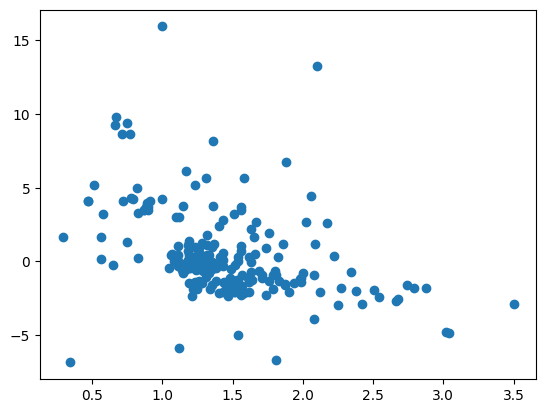

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

# Load the data
data = pd.read_csv('../4.dat', delim_whitespace=True, header=0)

# Select the 2nd and 5th columns (index 1 and 4)
selected_columns = data[[data.columns[3], data.columns[0]]]

# Display the result
print(selected_columns)
plt.scatter(selected_columns['Al'],selected_columns['RI'])


Defining the various kernels to be used and a function to shuffle the data and split it in into k dataframes for k-fold cross validation.

In [71]:
def gaussian_kernel(x1, x2, h):
    
    normalized_difference = (x1 - x2).astype(float) / h
    return np.exp(- (normalized_difference ** 2)/2) / np.sqrt(2 * np.pi)

def uniform_kernel(x1, x2, h):
    
    normalized_difference = (x1 - x2).astype(float) / h
    return (np.abs(normalized_difference)<1).astype(float)/2

def epanechnikov_kernel(x1, x2, h):

    normalized_difference = (x1 - x2).astype(float) / h
    return np.maximum(1-normalized_difference**2,0)*0.75

def shuffle_and_split(df, k):
    """
    Shuffle a DataFrame and split it into k datasets.

    Returns:
    list
        A list containing k DataFrames.
    """
    # Shuffle the DataFrame
    shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Split the DataFrame into k datasets
    split_dfs = np.array_split(shuffled_df, k)
    
    return split_dfs



Defining the functions to perform kernel regression and calculate error on training sets 

In [72]:
def kernel_regression(train_data, x, kernel, h):
    """
    Evaluate the value of estimated kernel regression function at a point x based on the training data ,specified 
    kernel function and bandwidth h
    """

    k_x_xi=kernel(train_data[:,0],x,h)
    sum1=np.sum(k_x_xi)

    k_x_xi_y=k_x_xi*train_data[:,1]
    sum2=np.sum(k_x_xi_y)
    
    if(sum1==0): return 0
    return sum2/sum1

def kernel_regression_multifeature(train_data, x, p, kernel, h):
    """
    Evaluate the value of estimated kernel regression function at a point x=(x1,x2,...xk) based on the training data ,
    specified kernel function ,bandwidth h and parameter p used to calculate distance between 2 points as 
    distance = (sum(xi_1-xi_2)**p)^1/p
    """
    
    dist = (train_data[:, :-1] - x[:,None])
    dist_p = np.power(np.sum(dist**p, axis=0),float(1)/p) 

    k_x_xi=kernel(dist_p,0,h)
    sum1=np.sum(k_x_xi)

    k_x_xi_y=k_x_xi*train_data[:,-1]
    sum2=np.sum(k_x_xi_y)
    
    if(sum1==0): return 0
    return sum2/sum1


def calc_error(train_data, cv_data, kernel, h):

    """
    Evaluate the square error of kernel density function estimated using the training data on cv_data 
    """

    square_error=0

    for i in range(cv_data.shape[0]):
        est = kernel_regression(train_data, cv_data[i][0], kernel, h)
        square_error+=(est-cv_data[i][1])**2

    return square_error

def calc_risk(data, kernel, h, k):

    """
    Evaluate the risk of kernel regression estimation using k-fold cross validation 
    Input :
    data - complete data
    kernel - gaussian/uniform/epanechnikov kernel
    h - bandwidth
    k - for k-fold cross validation
    """

    split_data=shuffle_and_split(data, k)
    total_error=0

    for i in range(k):
        # Concatenate test DataFrames into a single DataFrame
        combined_df = pd.concat([df for j, df in enumerate(split_data) if j != i] , ignore_index=True)

        # Convert the combined DataFrame to a NumPy array
        train_data = combined_df.to_numpy()
        test_data = split_data[i].to_numpy()
        
        total_error+=calc_error(train_data, test_data, kernel, h)

    return total_error/data.shape[0]



Using the Gaussian Kernel

As can be seen from the plot of risk vs bandwidth below, the optimum value of bandwidth(h) is close to 0.15. And the example plots for oversmooothed and undersmoothed versions have been obtained with h = 0.3 and h = 0.05 respectively.

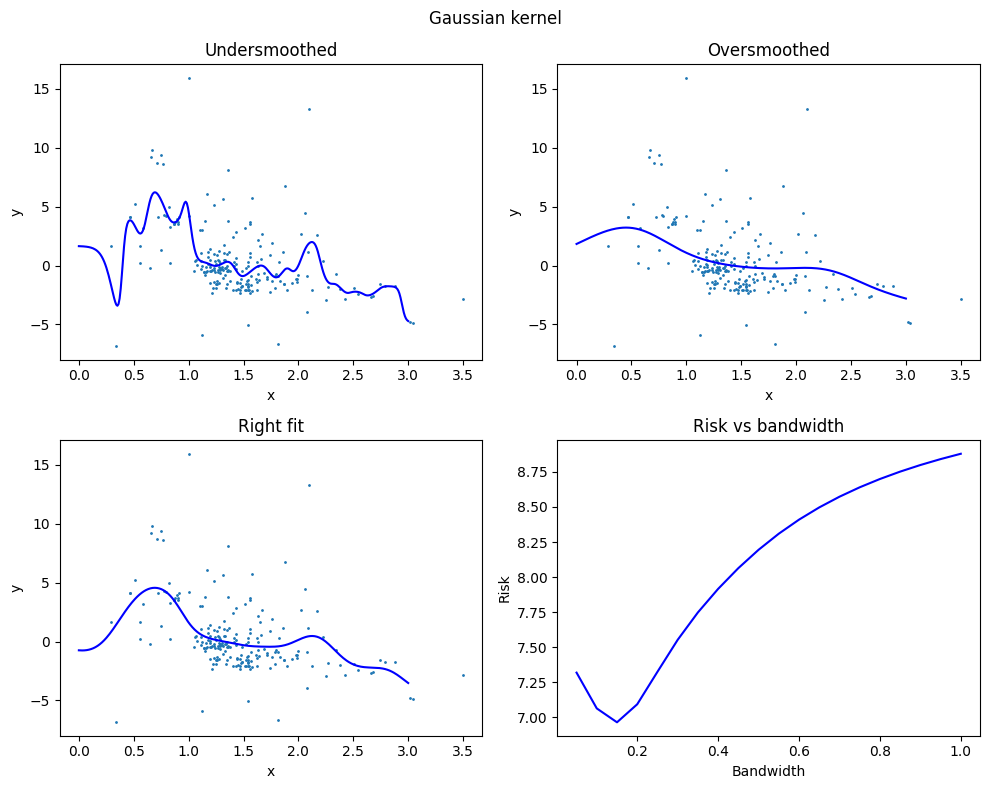

In [73]:

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

x = np.linspace(0,3,300)
x = list(x)
data = selected_columns.to_numpy()

# Undersmoothing in case of h = 0.05
y=[(kernel_regression(data, xi, gaussian_kernel, h = 0.05)) for xi in x]

axs[0, 0].scatter(selected_columns['Al'],selected_columns['RI'],s=1)
axs[0, 0].plot(x, y, 'blue')
axs[0, 0].set_title('Undersmoothed')
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")

# Oversmoothing in case of h = 0.3
y=[(kernel_regression(data, xi, gaussian_kernel, h = 0.3)) for xi in x]

axs[0, 1].scatter(selected_columns['Al'],selected_columns['RI'],s=1)
axs[0, 1].plot(x, y, 'blue')
axs[0, 1].set_title('Oversmoothed')
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")

#Right fit in case of h = 0.15
y=[(kernel_regression(data, xi, gaussian_kernel, h = 0.15)) for xi in x]

axs[1, 0].scatter(selected_columns['Al'],selected_columns['RI'],s=1)
axs[1, 0].plot(x, y, 'blue')
axs[1, 0].set_title('Right fit')
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel('y')

#plotting risk vs bandwidth using 5 fold cross validation

x=np.linspace(0.05,1,20)
y=[calc_risk(selected_columns, gaussian_kernel, i, 5) for i in x]

axs[1, 1].plot(x, y, 'blue')
axs[1, 1].set_title('Risk vs bandwidth')
axs[1, 1].set_xlabel("Bandwidth")
axs[1, 1].set_ylabel("Risk")

fig.suptitle("Gaussian kernel")

plt.tight_layout()
plt.savefig("../images/gaussian_kernel_regression.png")


Using the Epanechnikov Kernel

As can be seen from the plot of risk vs bandwidth below, the optimum value of bandwidth(h) is close to 0.3. And the example plots for oversmooothed and undersmoothed versions have been obtained with h = 0.6 and h = 0.1 respectively.

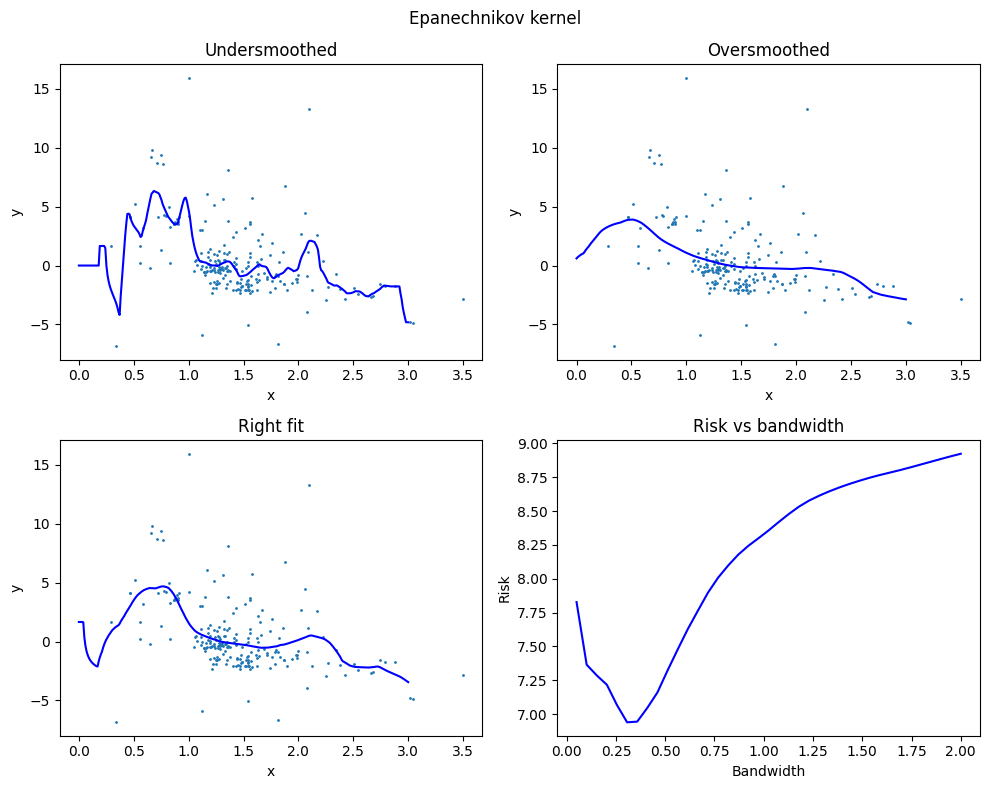

In [74]:

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

x = np.linspace(0,3,300)
x = list(x)
data = selected_columns.to_numpy()

# Undersmoothing in case of h = 0.1
y=[(kernel_regression(data, xi, epanechnikov_kernel, h = 0.1)) for xi in x]

axs[0, 0].scatter(selected_columns['Al'],selected_columns['RI'],s=1)
axs[0, 0].plot(x, y, 'blue')
axs[0, 0].set_title('Undersmoothed')
axs[0, 0].set_xlabel("x")
axs[0, 0].set_ylabel("y")

# Oversmoothing in case of h = 0.6
y=[(kernel_regression(data, xi, epanechnikov_kernel, h = 0.6)) for xi in x]

axs[0, 1].scatter(selected_columns['Al'],selected_columns['RI'],s=1)
axs[0, 1].plot(x, y, 'blue')
axs[0, 1].set_title('Oversmoothed')
axs[0, 1].set_xlabel("x")
axs[0, 1].set_ylabel("y")

#Right fit in case of h = 0.3
y=[(kernel_regression(data, xi, epanechnikov_kernel, h = 0.3)) for xi in x]

axs[1, 0].scatter(selected_columns['Al'],selected_columns['RI'],s=1)
axs[1, 0].plot(x, y, 'blue')
axs[1, 0].set_title('Right fit')
axs[1, 0].set_xlabel("x")
axs[1, 0].set_ylabel('y')

#plotting risk vs bandwidth using 5 fold cross validation

x=np.linspace(0.05,2,39)
y=[calc_risk(selected_columns, epanechnikov_kernel, i, 5) for i in x]

axs[1, 1].plot(x, y, 'blue')
axs[1, 1].set_title('Risk vs bandwidth')
axs[1, 1].set_xlabel("Bandwidth")
axs[1, 1].set_ylabel("Risk")

fig.suptitle("Epanechnikov kernel")

plt.tight_layout()
plt.savefig("../images/4/epanechnikov_kernel_regression.png")